### Show final calibration results
This notebook takes the final calibration results from quoFEM and plots the response of the system for samples of the calibrated parameters


In [48]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import time

In [4]:
# Local working directory (quoFEM)
localworkdir = r'C:\Users\Miguel.MIGUEL-DESK\Documents\quoFEM\LocalWorkDir\tmp.SimCenter'

# Explore files
os.listdir(localworkdir)

['cal_260.csv',
 'dakotaTab.out',
 'dakotaTabPrior.out',
 'log.txt',
 'logFileTMCMC.txt',
 'quoFEMTempCalibrationDataFile.cal',
 'response.csv',
 'resultsStage0.csv',
 'resultsStage1.csv',
 'resultsStage10.csv',
 'resultsStage11.csv',
 'resultsStage12.csv',
 'resultsStage13.csv',
 'resultsStage14.csv',
 'resultsStage2.csv',
 'resultsStage3.csv',
 'resultsStage4.csv',
 'resultsStage5.csv',
 'resultsStage6.csv',
 'resultsStage7.csv',
 'resultsStage8.csv',
 'resultsStage9.csv',
 'templatedir',
 'UCSD_UQ.err',
 'workdir.1',
 'workdir.10',
 'workdir.100',
 'workdir.1000',
 'workdir.101',
 'workdir.102',
 'workdir.103',
 'workdir.104',
 'workdir.105',
 'workdir.106',
 'workdir.107',
 'workdir.108',
 'workdir.109',
 'workdir.11',
 'workdir.110',
 'workdir.111',
 'workdir.112',
 'workdir.113',
 'workdir.114',
 'workdir.115',
 'workdir.116',
 'workdir.117',
 'workdir.118',
 'workdir.119',
 'workdir.12',
 'workdir.120',
 'workdir.121',
 'workdir.122',
 'workdir.123',
 'workdir.124',
 'workdir.12

In [22]:
# Load all data
cal_data = pd.read_csv(localworkdir + r'\response.csv')

# Extract columns 2 to 14
cal_data = cal_data.iloc[:, 2:14]
cal_data.head()

,gamma,eta1,sig,lam,mup,sigp,rsmax,alpha,alpha1,alpha2,betam1,kappa
0,0.613111,2.438194,0.416821,0.503981,4.421621,1.041831,0.826553,0.001613,19.010998,0.571832,0.000014,0.854071
1,0.630125,6.233344,0.452097,0.532181,3.111612,0.848838,0.956318,0.000795,68.915170,0.180574,0.000006,0.929752
2,0.593175,2.998264,0.357401,0.513539,1.321468,0.663224,0.726315,0.002159,11.292651,0.438351,0.000093,0.867272
3,0.635251,2.767653,0.357648,0.582816,2.590702,1.904649,0.854497,0.005132,14.114430,0.240304,0.000361,0.807174
4,0.574195,7.847548,0.383400,0.476835,3.607146,3.776884,0.979215,0.001796,61.192031,0.321854,0.000072,0.853172


In [46]:
# Import functions to create model
from column_model.material_models import *
from column_model.structure_model import *
from column_model.utilities import *

In [47]:
# Load the test data
testid = 260


In [91]:
def get_response(model_params, testid):

    # Get parameters into individual variables
    gamma = model_params['gamma']
    eta1 = model_params['eta1']
    sig = model_params['sig']
    lam = model_params['lam']
    mup = model_params['mup']
    sigp = model_params['sigp']
    rsmax = model_params['rsmax']
    alpha = model_params['alpha']
    alpha1 = model_params['alpha1']
    alpha2 = model_params['alpha2']
    betam1 = model_params['betam1']
    kappa = model_params['kappa']

    filesdir = r'C:\Users\Miguel.MIGUEL-DESK\Documents\GitHub\RC_Column_Model\test_data'
    with open(filesdir + '/test_' + str(testid).zfill(3) + '.json') as file:
        test_data = json.load(file)

    # Get the effective force of the test, if needed
    test_data["data"] = get_effective_force(test_data)
        
    # Define the elastic properties of the column
    E, I, L = get_elastic_properties(test_data)
        
    # Stiffness and strength of the plastic hinge
    stiffness =  10 * 3 * E * I / L   # kN-mm
    strength = 1000 * np.max(test_data["data"]["force"]) * L
        
    # Stiffness and strength of the plastic hinge (no need to update)
    k0 = stiffness
    sy0 = kappa * strength

    # Put them all in a list
    n = 2.0
    deg_bw_params = [eta1, k0, sy0, sig, lam, mup, sigp, rsmax, n, alpha, alpha1, alpha2, betam1]

    #% Create Plastic Hinge
    my_ph = deg_bw_material(deg_bw_params)

    # Elastic Parameters, mass and additional damping
    el_params = [gamma * E * I, L]   # [EI, L]
    mass = np.array([522, 1.0, 3.62e6])   # kips/g
    damping = [0.01]

    # Create structural model
    model = structure_model(el_params, my_ph, mass, damping)

    # Define the strains for the pushover analysis
    strains = np.array(test_data["data"]["disp"])
    #print(len(strains))

    # Define cycles for pushover
    t0 = time.time()
    force = run_pushover(model, strains, plot=False, show_info=False)
    t1 = time.time()

    print('Finished... Run Time = ', t1-t0, 'sec')

    peak_force = np.max(force)

    return strains, force, peak_force, L, test_data

gamma      0.558189
eta1       7.593746
sig        0.375736
lam        0.570622
mup        3.249340
sigp       2.353425
rsmax      0.919980
alpha      0.002340
alpha1    17.301562
alpha2     0.527945
betam1     0.000076
kappa      0.851533
Name: 507, dtype: float64
Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

Finished... Run Time =  1.1358025074005127 sec


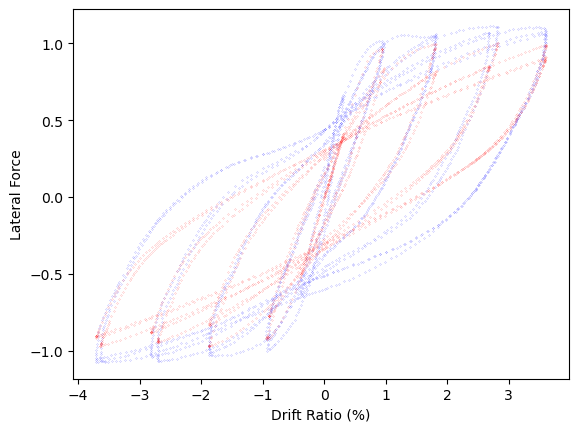

gamma     0.565519
eta1      8.344547
sig       0.417988
lam       0.582449
mup       2.196918
sigp      1.388263
rsmax     0.897987
alpha     0.002160
alpha1    7.505163
alpha2    0.358303
betam1    0.000097
kappa     0.877292
Name: 818, dtype: float64
Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

Finished... Run Time =  1.0951941013336182 sec


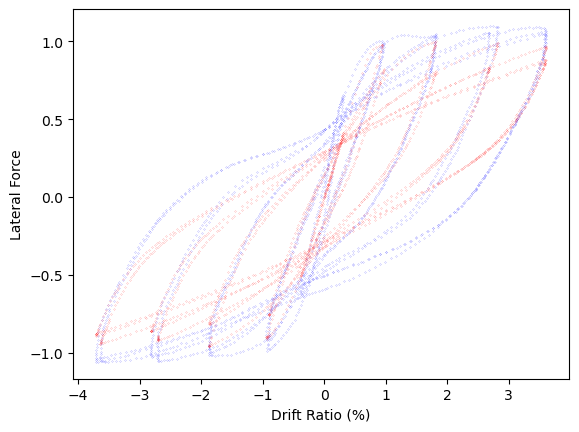

gamma      0.609407
eta1       3.617415
sig        0.395466
lam        0.491660
mup        2.806325
sigp       2.741989
rsmax      0.944220
alpha      0.001701
alpha1    25.190301
alpha2     0.645198
betam1     0.000057
kappa      0.863344
Name: 452, dtype: float64
Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

Finished... Run Time =  1.0264439582824707 sec


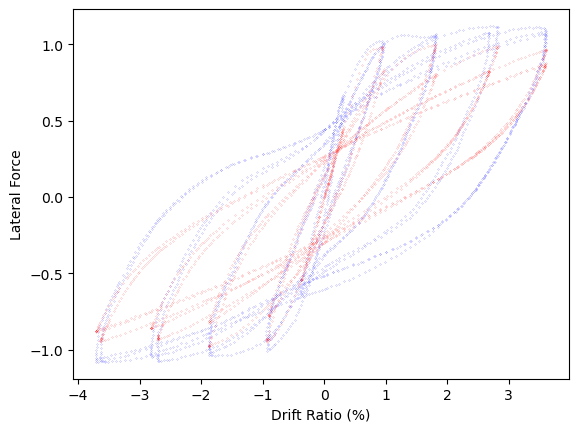

gamma     0.587705
eta1      8.377860
sig       0.427283
lam       0.639794
mup       4.537130
sigp      1.258306
rsmax     0.816913
alpha     0.002728
alpha1    4.713104
alpha2    0.483267
betam1    0.000182
kappa     0.847531
Name: 368, dtype: float64
Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

Finished... Run Time =  1.1610054969787598 sec


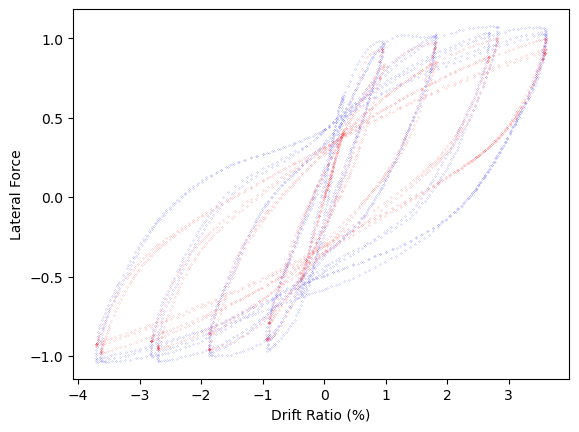

gamma     0.653859
eta1      3.334502
sig       0.527403
lam       0.629564
mup       2.314206
sigp      0.944949
rsmax     0.908293
alpha     0.001193
alpha1    6.107588
alpha2    0.307618
betam1    0.000032
kappa     0.869416
Name: 242, dtype: float64
Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

Finished... Run Time =  0.9437408447265625 sec


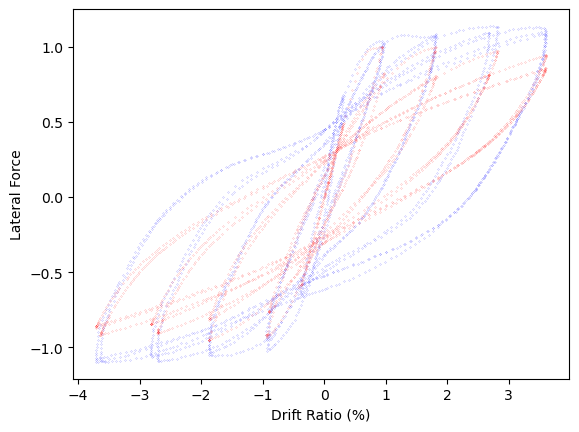

gamma      0.595252
eta1       6.456074
sig        0.475964
lam        0.491254
mup        2.265953
sigp       2.153431
rsmax      0.962735
alpha      0.000431
alpha1    29.679651
alpha2     0.246642
betam1     0.000038
kappa      0.883208
Name: 929, dtype: float64
Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

Finished... Run Time =  1.0171802043914795 sec


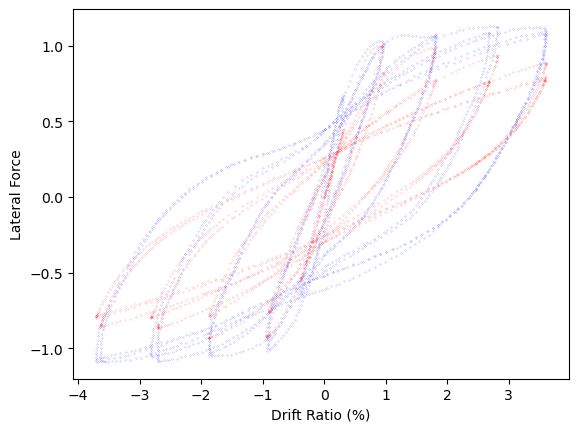

gamma      0.684475
eta1       5.629307
sig        0.464302
lam        0.568890
mup        4.541830
sigp       2.167551
rsmax      0.892450
alpha      0.001832
alpha1    39.206844
alpha2     0.429796
betam1     0.000223
kappa      0.856781
Name: 262, dtype: float64
Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

Finished... Run Time =  1.0085675716400146 sec


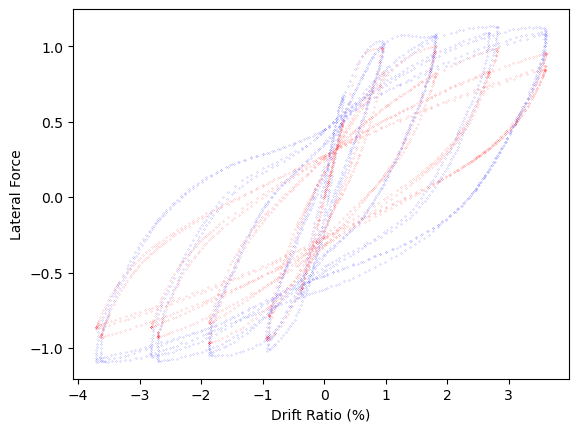

gamma     0.547520
eta1      5.819671
sig       0.279150
lam       0.510733
mup       3.330436
sigp      0.929097
rsmax     0.683948
alpha     0.002393
alpha1    5.564997
alpha2    0.288531
betam1    0.000120
kappa     0.860726
Name: 810, dtype: float64
Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

Finished... Run Time =  1.1609439849853516 sec


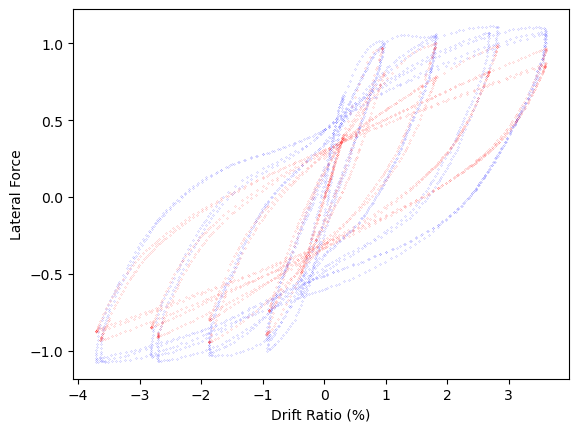

gamma      0.689837
eta1       1.859583
sig        0.537425
lam        0.524407
mup        2.621512
sigp       1.450282
rsmax      0.932107
alpha      0.000151
alpha1    21.183312
alpha2     0.601904
betam1     0.000016
kappa      0.894982
Name: 318, dtype: float64
Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

Finished... Run Time =  0.8385782241821289 sec


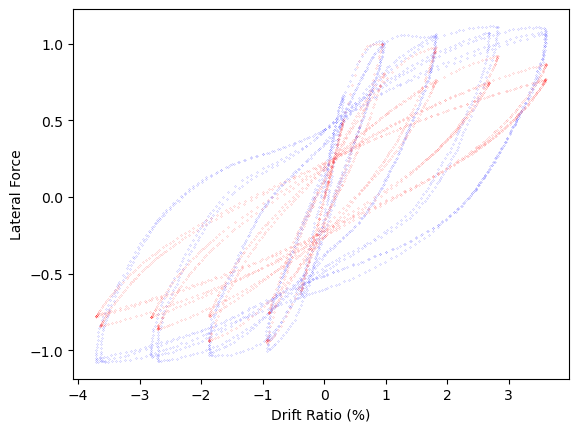

gamma      0.567051
eta1       8.673879
sig        0.383511
lam        0.426154
mup        2.967804
sigp       3.264263
rsmax      0.846520
alpha      0.001541
alpha1    14.615990
alpha2     0.393320
betam1     0.000060
kappa      0.835789
Name: 49, dtype: float64
Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

Finished... Run Time =  1.1367449760437012 sec


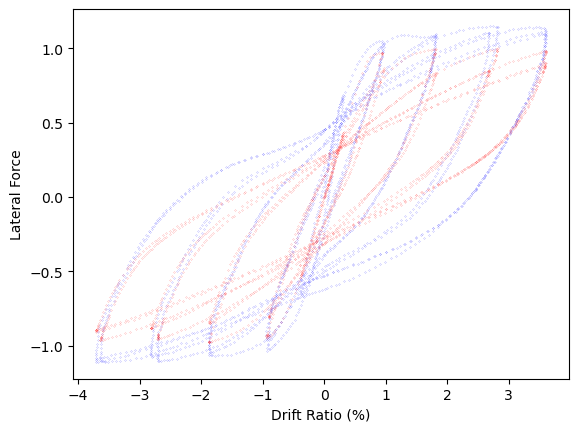

In [92]:
# Sample 10 random rows
model_params_mat = cal_data.sample(10, random_state=1)
testid = 260

for ii in range(0, len(model_params_mat)):
    model_params = model_params_mat.iloc[ii, :]

    print(model_params)
    strains, force, peak_force, L, test_data = get_response(model_params, testid)

    plt.figure()
    plt.plot(100 * np.array(test_data["data"]["disp"])/L, 1000 * np.array(test_data["data"]["force"])/peak_force, 'b.', markersize=0.2)
    plt.plot(100 * np.array(strains)/L, np.array(force)/peak_force, 'r.', markersize=0.2)
    plt.xlabel('Drift Ratio (%)')
    plt.ylabel('Lateral Force')
    plt.show()  